In [1]:
#import re
#from pyspark.sql import Row
#from pyspark.ml.feature import MinHashLSH, CountVectorizer
#from pyspark.sql import SparkSession
#from pyspark.sql.functions import col, count, desc, avg, min, max, from_unixtime, unix_timestamp, date_format, first, udf, substring, element_at
#from pyspark.sql.types import StringType,IntegerType

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#!pip install transformers

import transformers
from transformers import set_seed
from transformers import pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
set_seed(42)

# https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest
#https://huggingface.co/ProsusAI/finbert
# https://huggingface.co/nickmuchi/sec-bert-finetuned-finance-classification
# https://huggingface.co/SamLowe/roberta-base-go_emotions



/Users/annahan/opt/anaconda3/envs/env2/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-05-09 22:44:38.385911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data

## BTC Price History -- df_btc

In [2]:
# read in historical_bitcoin_data_2018_2023.csv
df_btc_raw = pd.read_csv('historical_bitcoin_data_2018_2023.csv')

# convert created_utx in unix to datetime
df_btc_raw['kline_close_time'] = pd.to_datetime(df_btc_raw['kline_close_time'], unit='ms')
# round kline_close_time to the nearest hour
df_btc_raw['kline_close_time'] = df_btc_raw['kline_close_time'].dt.round('H')
df_btc_raw.sort_values(by='kline_close_time', inplace=True)
# rename kline_close_time to timestamp
df_btc_raw.rename(columns={'kline_close_time': 'timestamp'}, inplace=True)

# create start timestamp, which is 1 hour before the timestamp
df_btc_raw['timestamp_start'] = df_btc_raw['timestamp'] - pd.Timedelta(hours=1)
df_btc_raw['timestamp_end'] = df_btc_raw['timestamp']

# create lookback window timestamp, which is xx hours before the timestamp
lookback_window = 24*14 # two weeks
df_btc_raw['timestamp_lookback'] = df_btc_raw['timestamp'] - pd.Timedelta(hours=lookback_window)

# create fields
df_btc_raw['taker_sell_base_asset_volume'] = df_btc_raw['volume'] - df_btc_raw['taker_buy_base_asset_volume']
df_btc_raw['taker_sell_quote_asset_volume'] = df_btc_raw['taker_sell_base_asset_volume'] * df_btc_raw['close_price']

# rename long fields
df_btc_raw.rename(columns={'taker_buy_base_asset_volume': 'buy_volume',
                           'taker_buy_quote_asset_volume': 'buy_notional',
                           'taker_sell_base_asset_volume': 'sell_volume',
                           'taker_sell_quote_asset_volume': 'sell_notional'
                           }, inplace=True)


# reset index
df_btc_raw.reset_index(drop=True, inplace=True)

# price returns -- FORWARD LOOKING***
# i.e. 2018-01-01 01:00:00 ret_1_h = 2018-01-01 02:00:00 / 2018-01-01 01:00:00 - 1
intervals = [1, 6, 1*24, 2*24, 3*24, 4*24, 5*24]
for interval in intervals:
    df_btc_raw[f'ret_{interval}_h'] = df_btc_raw['close_price'].pct_change(periods=interval)
    df_btc_raw[f'ret_{interval}_h'] = df_btc_raw[f'ret_{interval}_h'].shift(-interval)

df_btc_raw[['timestamp', 'close_price', 'ret_1_h', 'ret_6_h', 'ret_24_h', 'ret_48_h', 'ret_72_h', 'ret_96_h', 'ret_120_h']]

df_btc = df_btc_raw[['timestamp_lookback', 'timestamp', #'timestamp_start', 'timestamp_end',
                    'close_price',
                    #'volume', 'buy_volume', 'sell_volume',
                    #'num_of_trades',
                    'ret_1_h', 'ret_6_h', 'ret_24_h', 'ret_48_h', 'ret_72_h', 'ret_96_h', 'ret_120_h'
                    ]].copy()

df_btc

/var/folders/y_/p9bqtzbd0cd4xvrfxg_r0r180000gn/T/ipykernel_92427/4059835662.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_btc_raw['kline_close_time'] = df_btc_raw['kline_close_time'].dt.round('H')


,timestamp_lookback,timestamp,close_price,ret_1_h,ret_6_h,ret_24_h,ret_48_h,ret_72_h,ret_96_h,ret_120_h
0,2017-12-18 01:00:00,2018-01-01 01:00:00,13529.01,-0.024093,0.018582,0.016335,0.092063,0.090528,0.111685,0.258409
1,2017-12-18 02:00:00,2018-01-01 02:00:00,13203.06,0.009628,0.027819,0.030064,0.122467,0.149137,0.143531,0.252815
2,2017-12-18 03:00:00,2018-01-01 03:00:00,13330.18,0.005990,0.012739,0.014390,0.125872,0.133586,0.122668,0.239412
3,2017-12-18 04:00:00,2018-01-01 04:00:00,13410.03,0.014242,0.015433,-0.004195,0.105030,0.127512,0.105147,0.228192
4,2017-12-18 05:00:00,2018-01-01 05:00:00,13601.01,-0.003089,-0.002279,-0.034828,0.104305,0.093676,0.102859,0.223647
...,...,...,...,...,...,...,...,...,...,...
51723,2023-12-17 20:00:00,2023-12-31 20:00:00,42619.04,-0.001432,NaN,NaN,NaN,NaN,NaN,NaN
51724,2023-12-17 21:00:00,2023-12-31 21:00:00,42558.01,-0.000876,NaN,NaN,NaN,NaN,NaN,NaN
51725,2023-12-17 22:00:00,2023-12-31 22:00:00,42520.72,-0.006181,NaN,NaN,NaN,NaN,NaN,NaN
51726,2023-12-17 23:00:00,2023-12-31 23:00:00,42257.88,0.000608,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_btc_signal = df_btc.copy()

# signal threshold
ret_thresh = 0.005 # 0.5%
# where ret_ columns are > +ret_thresh, set value to +1; < -ret_thresh, set value to -1; else 0
for col in df_btc_signal.columns:
    if 'ret_' in col:
        df_btc_signal[col] = np.where(df_btc_signal[col] > ret_thresh, 1, np.where(df_btc_signal[col] < -ret_thresh, -1, 0))

df_btc_signal



,timestamp_lookback,timestamp,close_price,ret_1_h,ret_6_h,ret_24_h,ret_48_h,ret_72_h,ret_96_h,ret_120_h
0,2017-12-18 01:00:00,2018-01-01 01:00:00,13529.01,-1,1,1,1,1,1,1
1,2017-12-18 02:00:00,2018-01-01 02:00:00,13203.06,1,1,1,1,1,1,1
2,2017-12-18 03:00:00,2018-01-01 03:00:00,13330.18,1,1,1,1,1,1,1
3,2017-12-18 04:00:00,2018-01-01 04:00:00,13410.03,1,1,0,1,1,1,1
4,2017-12-18 05:00:00,2018-01-01 05:00:00,13601.01,0,0,-1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
51723,2023-12-17 20:00:00,2023-12-31 20:00:00,42619.04,0,0,0,0,0,0,0
51724,2023-12-17 21:00:00,2023-12-31 21:00:00,42558.01,0,0,0,0,0,0,0
51725,2023-12-17 22:00:00,2023-12-31 22:00:00,42520.72,-1,0,0,0,0,0,0
51726,2023-12-17 23:00:00,2023-12-31 23:00:00,42257.88,0,0,0,0,0,0,0


## Reddit Submissions Sentiment Data

df_sub_senti

In [4]:
#data_path_sub = "gcs/stonkgo/reddit-data-bitcoin/filtered_data/submissions/submissions_06-30-12-31-2023"
#data_path_sub = "submissions_06-30-12-31-2023"
data_path_sub = "submissions_09-30-12-31-2023"

df_sub_raw = pd.read_parquet(data_path_sub)
#print(df_sub_raw.dtypes)

# drop nas
df_sub_raw.dropna(subset=["selftext"], inplace=True)
df_sub_raw.selftext = df_sub_raw.selftext.astype("string")

# add selftext truncated to 514 characters
df_sub_raw['selftext_trunc'] = df_sub_raw['selftext'].apply(lambda x: x[:514])

# calc original length of text
df_sub_raw['length'] = df_sub_raw['selftext'].apply(len)
df_sub_raw['length_trunc'] = df_sub_raw['selftext_trunc'].apply(len)

# convert created_utx in unix to datetime
df_sub_raw['created_utc'] = pd.to_datetime(df_sub_raw['created_utc'], unit='s')
# rename as 'timestamp'
df_sub_raw.rename(columns={'created_utc': 'timestamp'}, inplace=True)
# convert to EST, adjusting for daylight savings 
#df_sub_raw['created_utc'] = df_sub_raw['created_utc'] - pd.Timedelta(hours=5) - pd.Timedelta(hours=1)



print('df_sub_raw shape:', df_sub_raw.shape)

# trim
df_sub = df_sub_raw.copy()

# format fields into different data types
# score must be integer
df_sub['score'] = df_sub['score'].astype(int)
df_sub = df_sub.loc[df_sub['score'] > 1].reset_index(drop = True).copy()

print('df_sub shape:', df_sub.shape)

df_sub.sort_values(['score'], ascending = [False])

#df_sub_raw.dtypes

df_sub_raw shape: (8300, 52)
df_sub shape: (2931, 52)


/var/folders/y_/p9bqtzbd0cd4xvrfxg_r0r180000gn/T/ipykernel_92427/276117806.py:20: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_sub_raw['created_utc'] = pd.to_datetime(df_sub_raw['created_utc'], unit='s')


,archived,author,can_gild,contest_mode,timestamp,gilded,hidden,id,is_crosspostable,is_self,...,removed_by_category,post_hint,link_flair_text,author_created_utc,author_flair_css_class,secure_media,link_flair_css_class,selftext_trunc,length,length_trunc
1434,False,surrogate_uprising,False,False,2023-12-03 22:37:32,0,False,18a5g8y,True,True,...,None,nan,None,nan,None,None,None,Congratulations to all hodlers and those with ...,75,75
369,False,spitefully_empty,False,False,2023-11-08 18:16:51,0,False,17qrtho,True,False,...,None,image,None,nan,None,None,None,I have 5 BITCOINS. Here is my advice & journey...,4256,514
972,False,i_say_fuckin,False,False,2023-11-23 14:07:11,0,False,1821xx8,True,True,...,None,nan,None,nan,None,None,None,Am I gonna be ok?,17,17
641,False,hitma-n,False,False,2023-11-15 12:29:53,0,False,17vsmam,True,True,...,None,nan,None,nan,None,None,None,Just wanted to share my happiness and exciteme...,208,208
384,False,reddit4485,False,False,2023-11-09 04:31:34,0,False,17r51k0,True,True,...,None,nan,None,nan,None,None,None,"Microstrategy bought 158,400 bitcoin at an ave...",68,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,False,Longjumping-Low3164,False,False,2023-12-12 12:57:48,0,False,18glacf,True,True,...,None,nan,None,nan,None,None,None,Hello. I want to share some of my thoughts.\n\...,671,514
655,False,Mr_InstantNoodle,False,False,2023-11-15 19:40:40,0,False,17w1sfd,True,True,...,None,nan,None,nan,None,None,None,Let’s say if I don’t have RBF or CPFP availabl...,230,230
2496,False,BigTdick07,False,False,2023-12-22 04:42:44,0,False,18o6p9l,True,False,...,None,link,None,nan,None,None,None,"Don’t be a fool, buy Bitcoin and immediately t...",411,411
2016,False,paolorepetti85,False,False,2023-12-12 12:10:49,0,False,18gkht4,True,True,...,None,nan,None,nan,None,None,None,"Hi,\nI just bought a brand new HD wallet and I...",551,514


In [5]:
# check rangge of lengths
df_sub.describe()


,timestamp,score,length,length_trunc
count,2931,2931.000000,2931.000000,2931.000000
mean,2023-12-01 20:07:10.589218560,45.761856,515.819857,321.522689
min,2023-09-30 16:32:59,2.000000,1.000000,1.000000
25%,2023-11-17 15:24:31.500000,3.000000,161.000000,161.000000
50%,2023-12-04 12:03:08,8.000000,332.000000,332.000000
75%,2023-12-16 04:04:40,31.000000,597.000000,514.000000
max,2023-12-31 07:58:42,1942.000000,15209.000000,514.000000
std,NaN,119.885696,758.916953,174.235063


In [6]:
## CHOSE MODEL --> get results

## <- double hash are lines to uncomment to run

#model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
##classifier_twitter = pipeline("sentiment-analysis",
##  model="cardiffnlp/twitter-roberta-base-sentiment-latest", 
##    tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest")
#classification_results = classifier_twitter("Covid cases are increasing fast!")


classifier_emotions = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)
#sentences = ["I am not having a great day"]
#classifier_emotions(sentences)
#print(model_emotions_outputs[0])
classification_results = classifier_emotions(df_sub.selftext_trunc.to_list())

#classification_results

In [7]:
## MASSAGE RESULTS


# TWITTER MODEL
#df_result_twitter = pd.DataFrame(classifier_twitter(df_sub.selftext_trunc.to_list()))
#df_result_twitter.columns = ['senti_label', 'senti_score'] # rename columns



# EMOTIONS MODEL

#df_result_emotions2 = pd.DataFrame(
#    [{'input': input, 'classification_result': result} for input, result in zip(df_sub.selftext_trunc.to_list(), classification_results)]
#)

#df_result_emotions = pd.DataFrame([result for result in classification_results])
#df = pd.DataFrame([result['scores'] for result in classification_results])

df_result_emotions_temp = pd.DataFrame(
    [{'classification_result': result} for result in classification_results]
)
# create empty dataframe with column names of each emotion
senti_prefix = 'senti_'
df_results_emotions = pd.DataFrame(columns=[senti_prefix + x['label'] for x in classification_results[0]])


# Iterate over the classification results
for result in classification_results:
    # Extract the scores for each emotion label
    scores = [x['score'] for x in result]
    
    # Create a dictionary with emotion labels as keys and scores as values
    #emotion_scores = {x['label']: x['score'] for x in result} # without prefix
    emotion_scores = {senti_prefix + x['label']: x['score'] for x in result}

    # Concatenate the emotion scores to the dataframe
    df_results_emotions = pd.concat([df_results_emotions, pd.DataFrame(emotion_scores, index=[0])], ignore_index=True)



df_results_emotions

df_senti = df_results_emotions.copy()

df_senti

# access the classification result in order of the listed emotions
#print(df_result_emotions['classification_result'][0][0]['label'])
#print(df_result_emotions['classification_result'][0][0]['score'])

# access entire dictionary of classification results
#df_result_emotions['classification_result'][0]
# get first three elements of the classification result
#df_result_emotions['classification_result'][0][:3]

# get maximum score and corresponding label
#max_score = max([x['score'] for x in df_result_emotions['classification_result'][0]])
#max_label = [x['label'] for x in df_result_emotions['classification_result'][0] if x['score'] == max_score]
#print(max_score)
#print(max_label)


# split each emotion and emotion score into separate columns
#df = pd.DataFrame([{emotion: score for emotion, score in result['scores'].items()} for result in classification_results])


/var/folders/y_/p9bqtzbd0cd4xvrfxg_r0r180000gn/T/ipykernel_92427/2222746854.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_emotions = pd.concat([df_results_emotions, pd.DataFrame(emotion_scores, index=[0])], ignore_index=True)


,senti_neutral,senti_approval,senti_realization,senti_annoyance,senti_confusion,senti_disapproval,senti_optimism,senti_curiosity,senti_admiration,senti_disappointment,...,senti_gratitude,senti_desire,senti_surprise,senti_love,senti_embarrassment,senti_relief,senti_nervousness,senti_remorse,senti_grief,senti_pride
0,0.959776,0.021834,0.008161,0.006150,0.004533,0.003171,0.002837,0.002582,0.002159,0.001893,...,0.000775,0.000720,0.000717,0.000616,0.000345,0.000260,0.000255,0.000226,0.000218,0.000209
1,0.136663,0.022219,0.009470,0.006582,0.005855,0.005451,0.018187,0.002468,0.001849,0.001493,...,0.886894,0.002215,0.000714,0.000522,0.000484,0.001850,0.000239,0.001483,0.000326,0.000391
2,0.305590,0.057557,0.108550,0.012508,0.004578,0.007727,0.007817,0.009389,0.020854,0.011456,...,0.000814,0.001346,0.445540,0.000982,0.002336,0.001375,0.000573,0.000356,0.000633,0.001187
3,0.127372,0.011777,0.206024,0.033542,0.004911,0.008738,0.009995,0.006370,0.002836,0.238788,...,0.000913,0.005168,0.461680,0.003273,0.017264,0.007693,0.010866,0.002678,0.004290,0.001546
4,0.495109,0.022240,0.013564,0.024156,0.430422,0.010737,0.010596,0.343367,0.000953,0.004864,...,0.000577,0.001991,0.003389,0.000752,0.001077,0.000380,0.001151,0.001181,0.000383,0.000123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,0.382665,0.015702,0.024254,0.007540,0.114701,0.003712,0.007882,0.460348,0.004492,0.004011,...,0.000902,0.001930,0.208763,0.001110,0.001730,0.000493,0.001190,0.000590,0.000521,0.000218
2927,0.250892,0.008417,0.006199,0.005713,0.385116,0.004124,0.015221,0.625303,0.001862,0.002353,...,0.000978,0.002752,0.007498,0.002389,0.000587,0.000201,0.000793,0.000676,0.000282,0.000069
2928,0.143917,0.022080,0.009900,0.006810,0.006214,0.005784,0.018531,0.002535,0.001748,0.001541,...,0.879730,0.002193,0.000720,0.000512,0.000492,0.001866,0.000246,0.001524,0.000332,0.000386
2929,0.747984,0.347197,0.032114,0.006534,0.002367,0.004320,0.035901,0.001206,0.005160,0.002246,...,0.000529,0.002709,0.000897,0.000851,0.000234,0.000943,0.000330,0.000163,0.000154,0.000631


In [8]:
## MERGE RESULTS WITH ORIGINAL DATA
# df_senti or df_senti_scaled

df_sub_senti = pd.concat([df_sub, df_senti], axis=1)
#df_sub_senti = pd.concat([df_sub, df_senti_scaled], axis=1)

df_sub_senti

# create score quantiles
df_sub_senti['score_quantile'] = (pd.qcut(df_sub_senti['score'], q=5, labels=False) + 1)**2

# count how many submissions are in each quantile
df_sub_senti['score_quantile'].value_counts()

# select weighting metric #######
df_sub_senti['weight'] = df_sub_senti['score_quantile'].copy()

df_sub_senti.head(2)

,archived,author,can_gild,contest_mode,timestamp,gilded,hidden,id,is_crosspostable,is_self,...,senti_surprise,senti_love,senti_embarrassment,senti_relief,senti_nervousness,senti_remorse,senti_grief,senti_pride,score_quantile,weight
0,False,Odd-Cut-7365,False,False,2023-09-30 16:32:59,0,False,16wbb8h,True,True,...,0.000717,0.000616,0.000345,0.00026,0.000255,0.000226,0.000218,0.000209,25,25
1,False,rBitcoinMod,False,False,2023-10-01 06:07:57,0,False,16wtceh,True,True,...,0.000714,0.000522,0.000484,0.00185,0.000239,0.001483,0.000326,0.000391,16,16


### Reddit Sentiment Plots , EDA

<Axes: xlabel='score_quantile', ylabel='senti_joy'>

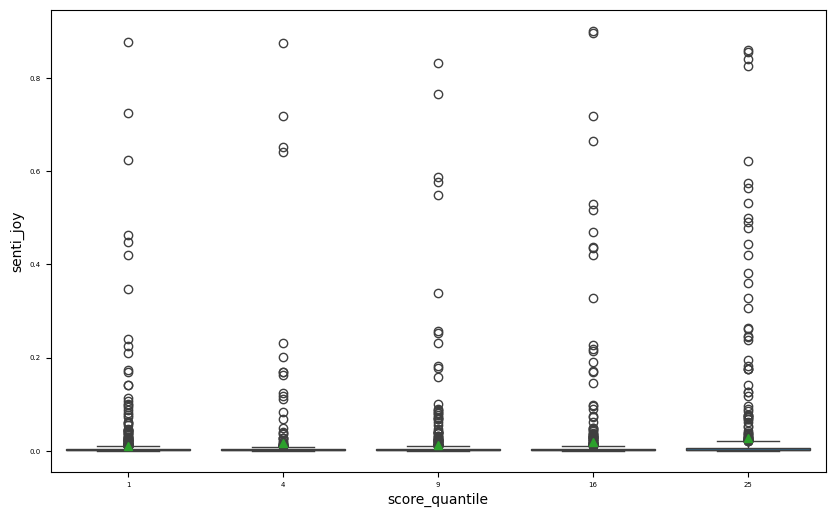

In [9]:
# BOX PLOTS
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator

# plot settings
plt.figure(figsize=(10, 6))
plt.tick_params(axis='both', which='major', labelsize=5) # make axis ticker labels smaller

## all samples, all sentiment labels
#sns.boxplot(data = df_senti, orient = 'v')


# bucket samples, single sentiment label
sns.boxplot(data = df_sub_senti, 
            x = 'score_quantile', y = 'senti_joy', 
            showmeans = True,
            whis = 3,
            #palette = 'Set1',
            #hue = 'score_quantile',
            orient = 'v')



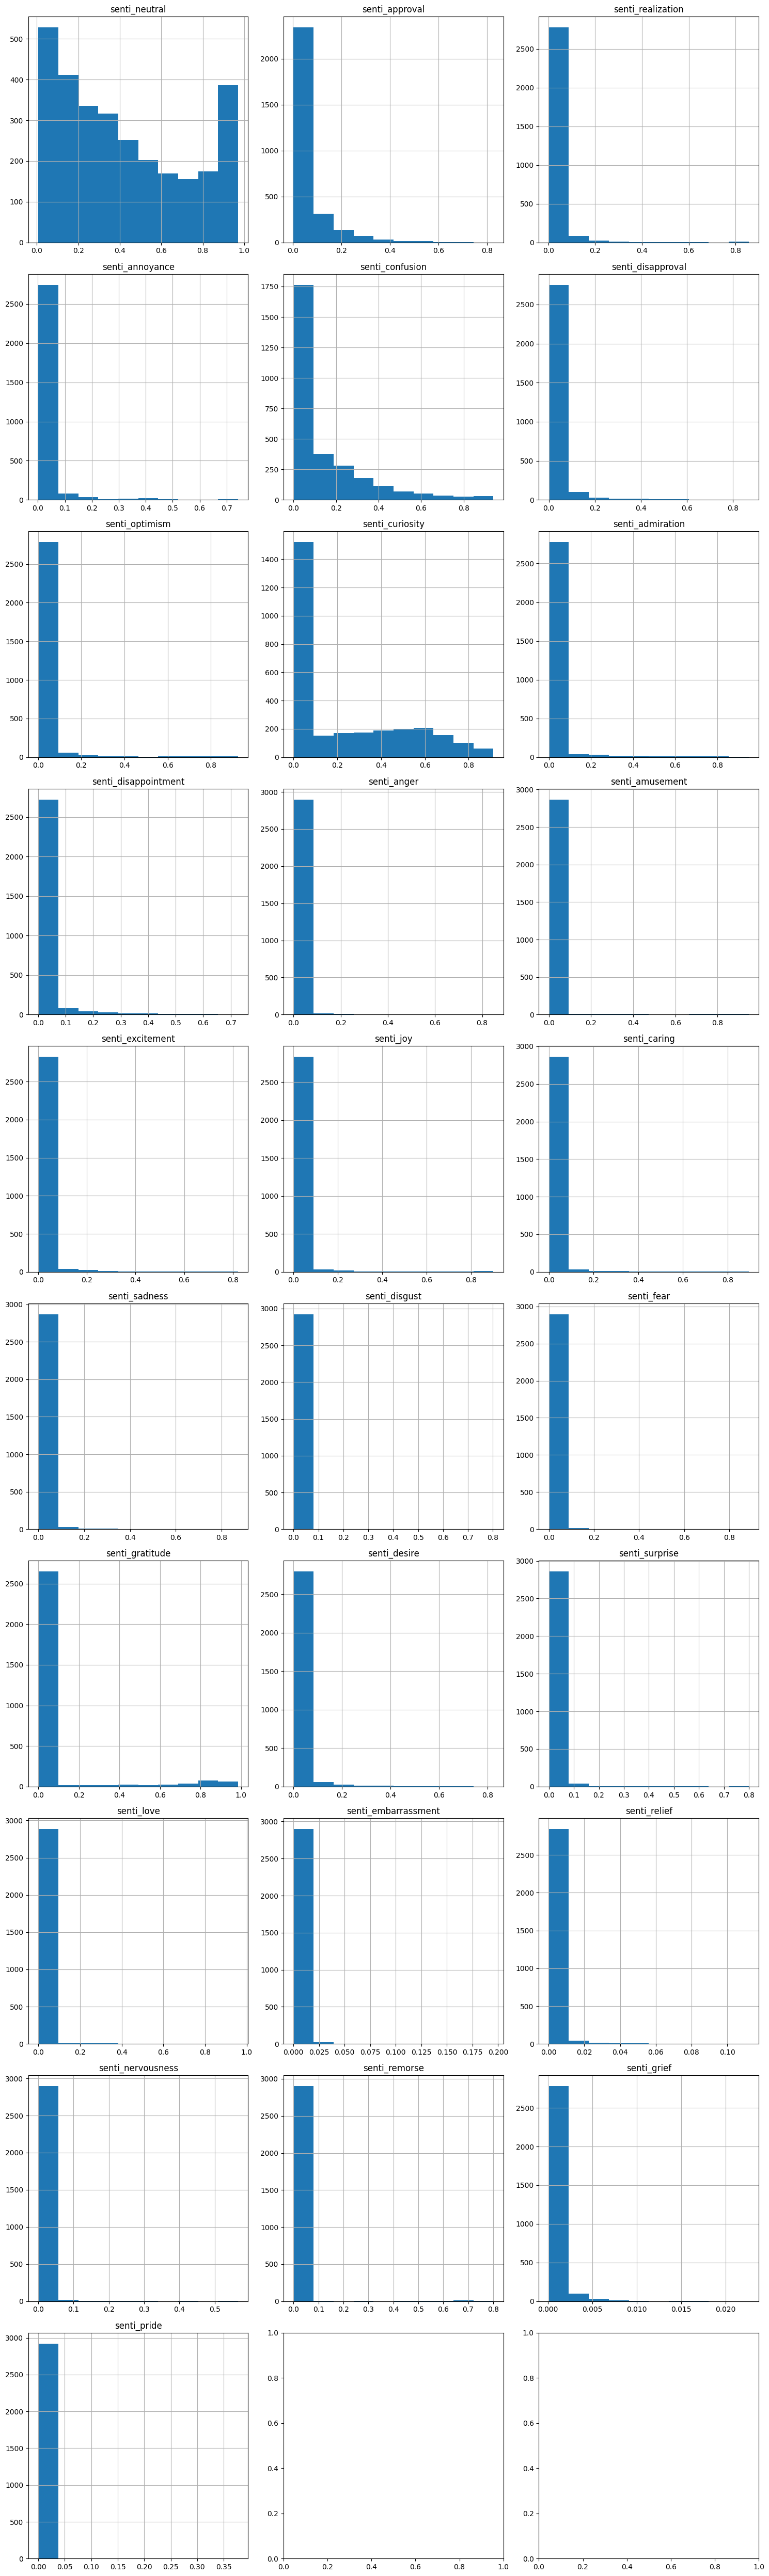

In [10]:
# Get the list of column names in df_senti
columns = df_senti.columns

# Calculate the number of rows and columns for the subplots
num_rows = len(columns) // 3 + len(columns) % 3
num_cols = 3

# Create a multi-grid plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Iterate over each column and plot the distribution
for i, column in enumerate(columns):
    row = i // num_cols
    col = i % num_cols
    df_senti[column].hist(ax=axes[row, col])
    axes[row, col].set_title(column)

# Adjust the layout and spacing
plt.tight_layout()

# Show the plot
plt.show()


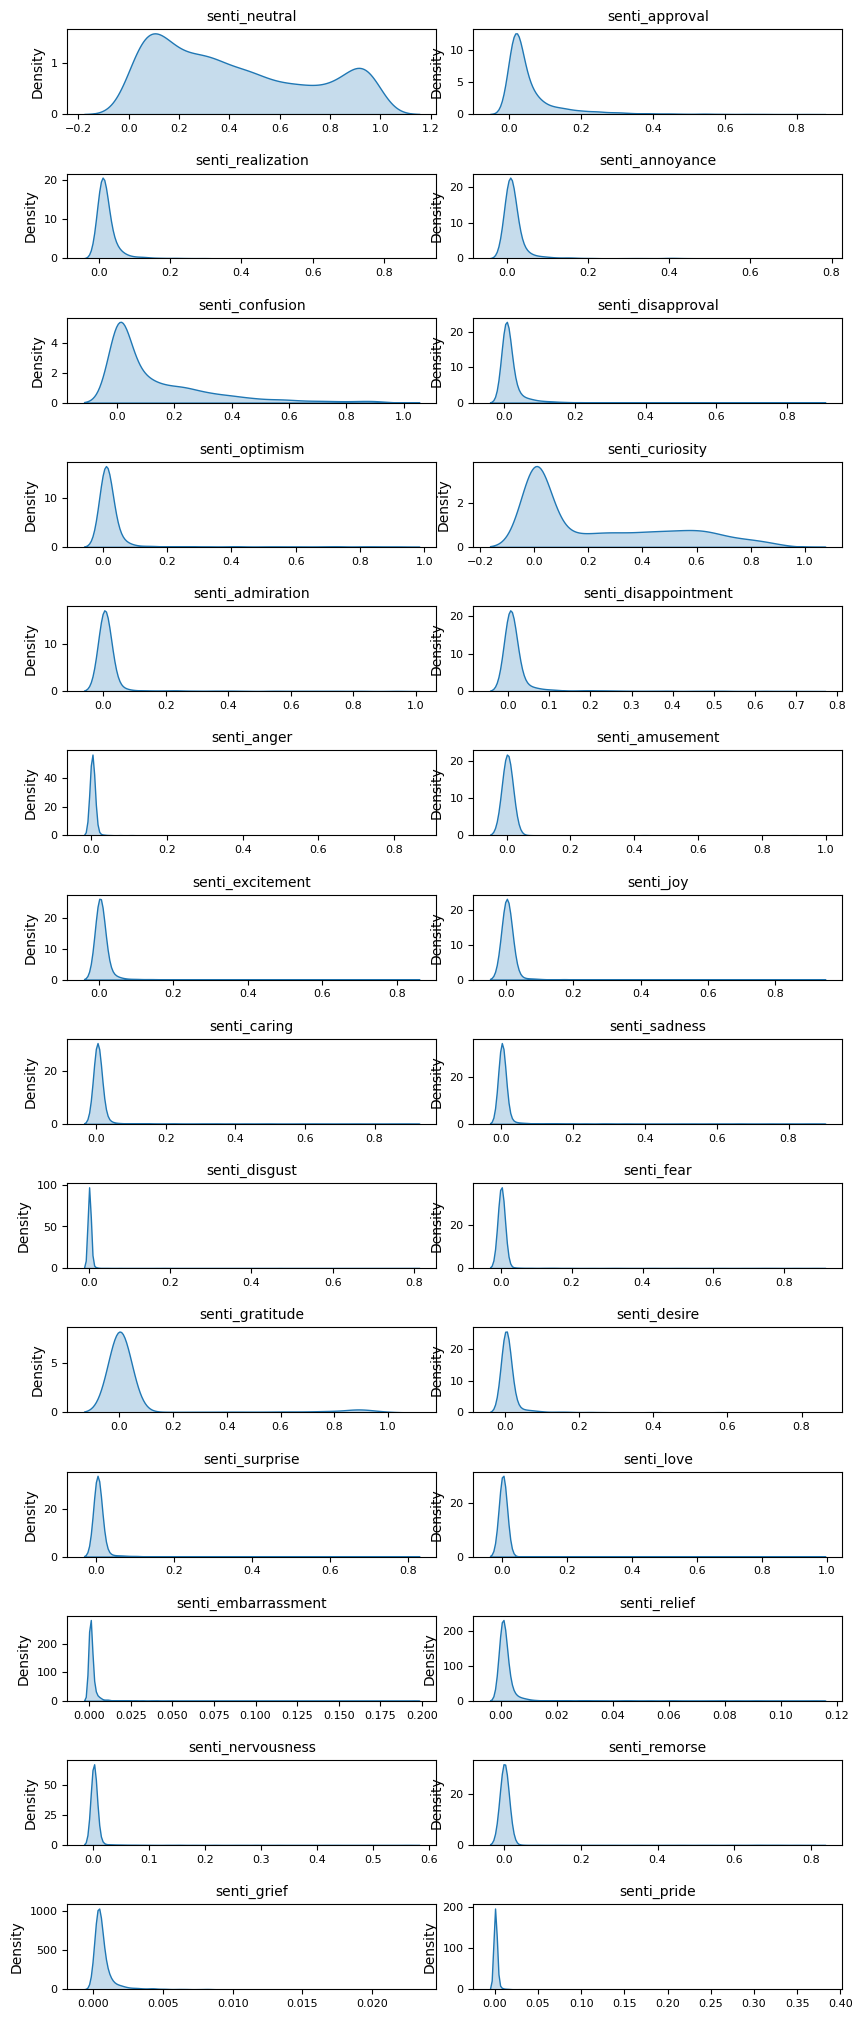

In [11]:
# Get the list of column names in df_senti
columns = df_senti.columns

# Calculate the number of rows and columns for the subplots
num_rows = len(columns) // 2 + len(columns) % 2
num_cols = 2

# Create a multi-grid plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 1*len(columns)))

# Iterate over each column and plot the distribution
for i, column in enumerate(columns):
    row = i // num_cols
    col = i % num_cols
    ax = sns.kdeplot(data=df_senti, x=column, fill=True, ax=axes[row, col])
    ax.set_title(column, fontsize=10)  # Add title to subplot with smaller font size
    ax.tick_params(axis='both', which='major', labelsize=8)  # Set tick label font size
    ax.set_xlabel('')  # Remove x-axis label

# Adjust the layout and spacing
plt.subplots_adjust(hspace=0.7, wspace=0.1, top=0.9, bottom=0.2)

# Show the plot
plt.show()


## JOIN: BTC and SUBMISSIONS SENTIMENT

### Rolling Lookback Window

In [12]:
#df_sub_senti
#df_btc_signal

df_merged = df_btc_signal.copy()

#df_merged = df_merged.iloc[50000:51728, :].reset_index(drop = True).copy()
#df_merged = df_merged.iloc[50005:50006, :].reset_index(drop = True).copy()

# trim to where we have data for df_sub_senti
df_merged = df_merged.loc[df_merged.timestamp_lookback >= df_sub_senti.timestamp.min()].reset_index(drop = True).copy()


#df_merged = df_merged.iloc[1849:1851,:].reset_index(drop=True)

df_merged

,timestamp_lookback,timestamp,close_price,ret_1_h,ret_6_h,ret_24_h,ret_48_h,ret_72_h,ret_96_h,ret_120_h
0,2023-09-30 17:00:00,2023-10-14 17:00:00,26926.58,0,0,0,1,1,1,1
1,2023-09-30 18:00:00,2023-10-14 18:00:00,26889.51,0,0,0,1,1,1,1
2,2023-09-30 19:00:00,2023-10-14 19:00:00,26870.00,0,0,1,1,1,1,1
3,2023-09-30 20:00:00,2023-10-14 20:00:00,26864.29,0,0,1,1,1,1,1
4,2023-09-30 21:00:00,2023-10-14 21:00:00,26845.32,0,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
1875,2023-12-17 20:00:00,2023-12-31 20:00:00,42619.04,0,0,0,0,0,0,0
1876,2023-12-17 21:00:00,2023-12-31 21:00:00,42558.01,0,0,0,0,0,0,0
1877,2023-12-17 22:00:00,2023-12-31 22:00:00,42520.72,-1,0,0,0,0,0,0
1878,2023-12-17 23:00:00,2023-12-31 23:00:00,42257.88,0,0,0,0,0,0,0


In [13]:
df_sub_senti.head(2)

,archived,author,can_gild,contest_mode,timestamp,gilded,hidden,id,is_crosspostable,is_self,...,senti_surprise,senti_love,senti_embarrassment,senti_relief,senti_nervousness,senti_remorse,senti_grief,senti_pride,score_quantile,weight
0,False,Odd-Cut-7365,False,False,2023-09-30 16:32:59,0,False,16wbb8h,True,True,...,0.000717,0.000616,0.000345,0.00026,0.000255,0.000226,0.000218,0.000209,25,25
1,False,rBitcoinMod,False,False,2023-10-01 06:07:57,0,False,16wtceh,True,True,...,0.000714,0.000522,0.000484,0.00185,0.000239,0.001483,0.000326,0.000391,16,16


In [14]:
df_senti_rolling = pd.DataFrame()
df_senti_rolling_wgt = pd.DataFrame()
for col in df_sub_senti.columns:
    if 'senti_' in col:
        df_senti_rolling[col] = 0
        df_senti_rolling_wgt[col] = 0
df_senti_rolling
df_senti_rolling_wgt

for i in range(len(df_merged)):
    # get the start and end timestamp of the time window
    start = df_merged.loc[i, 'timestamp_lookback']
    end = df_merged.loc[i, 'timestamp']
    
    # subset df_sub_senti to only include rows that fall within the time window, and
    # recall: 'weight'
    df_window = df_sub_senti.loc[(df_sub_senti['timestamp'] >= start) & (df_sub_senti['timestamp'] < end)].copy()
    #print('window shape', df_window.shape)
    
    # subset of df_sub_senti_window with column names that contain 'senti_'
    df_window_senti = df_window[[col for col in df_window.columns if 'senti_' in col]].copy()

    # calc average and wgt average of df_window_senti , weighted by df_window.weight
    sum_of_weights = df_window['weight'].sum()
    df_window_senti_weighted_avg = df_window_senti.mul(df_window['weight'], axis=0).sum(axis = 0).to_frame().T / sum_of_weights
    count_of_obs = df_window.shape[0]
    df_window_senti_avg = df_window_senti.mean(axis = 0).to_frame().T

    # concat df_avg_senti to df_senti_rolling
    df_senti_rolling_wgt = pd.concat([df_senti_rolling_wgt, df_window_senti_weighted_avg], ignore_index=True)
    df_senti_rolling = pd.concat([df_senti_rolling, df_window_senti_avg], ignore_index=True)

df_senti_rolling_wgt.reset_index(drop=True, inplace=True)
df_senti_rolling.reset_index(drop=True, inplace=True)

print(df_senti_rolling.shape)
print(df_senti_rolling_wgt.shape)


(1880, 28)
(1880, 28)


In [15]:

# add weighted avg sentiment columns
df_merged_wgt = pd.concat([df_merged, df_senti_rolling_wgt], axis=1).copy()
df_merged = pd.concat([df_merged, df_senti_rolling], axis=1).copy()
print(df_merged.shape)
print(df_merged_wgt.shape)
print(df_merged.timestamp.max())
print(df_merged.timestamp.min())

# drop rows with NaN
df_merged.dropna(inplace=True)
df_merged_wgt.dropna(inplace=True)

# timestamp_lookback > df_sub_senti.timestamp.min()
df_merged = df_merged.loc[df_merged.timestamp_lookback >= df_sub_senti.timestamp.min()].reset_index(drop = True).copy()
df_merged_wgt = df_merged_wgt.loc[df_merged_wgt.timestamp_lookback >= df_sub_senti.timestamp.min()].reset_index(drop = True).copy()

#df_merged

(1880, 38)
(1880, 38)
2024-01-01 00:00:00
2023-10-14 17:00:00


In [16]:
print(df_merged.columns)

#df_merged.describe()

Index(['timestamp_lookback', 'timestamp', 'close_price', 'ret_1_h', 'ret_6_h',
       'ret_24_h', 'ret_48_h', 'ret_72_h', 'ret_96_h', 'ret_120_h',
       'senti_neutral', 'senti_approval', 'senti_realization',
       'senti_annoyance', 'senti_confusion', 'senti_disapproval',
       'senti_optimism', 'senti_curiosity', 'senti_admiration',
       'senti_disappointment', 'senti_anger', 'senti_amusement',
       'senti_excitement', 'senti_joy', 'senti_caring', 'senti_sadness',
       'senti_disgust', 'senti_fear', 'senti_gratitude', 'senti_desire',
       'senti_surprise', 'senti_love', 'senti_embarrassment', 'senti_relief',
       'senti_nervousness', 'senti_remorse', 'senti_grief', 'senti_pride'],
      dtype='object')


### EDA of Merged BTC/Senti

In [17]:
df_btc_raw.describe()
df_senti_rolling.describe()
df_senti_rolling_wgt.describe()
df_merged.describe()


,timestamp_lookback,timestamp,close_price,ret_1_h,ret_6_h,ret_24_h,ret_48_h,ret_72_h,ret_96_h,ret_120_h,...,senti_gratitude,senti_desire,senti_surprise,senti_love,senti_embarrassment,senti_relief,senti_nervousness,senti_remorse,senti_grief,senti_pride
count,1880,1880,1880.000000,1880.000000,1880.000000,1880.000000,1880.000000,1880.000000,1880.000000,1880.000000,...,1880.000000,1880.000000,1880.000000,1880.000000,1880.000000,1880.000000,1880.000000,1880.000000,1880.000000,1880.000000
mean,2023-11-08 20:30:00,2023-11-22 20:30:00,37698.158138,0.013830,0.078191,0.151064,0.267553,0.350000,0.356915,0.383511,...,0.068672,0.018456,0.014956,0.008175,0.001851,0.002391,0.004264,0.005632,0.000792,0.002701
min,2023-09-30 17:00:00,2023-10-14 17:00:00,26820.010000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.015519,0.008774,0.004050,0.002243,0.000895,0.001483,0.001957,0.000815,0.000522,0.000684
25%,2023-10-20 06:45:00,2023-11-03 06:45:00,34732.537500,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,...,0.064477,0.016603,0.009103,0.007316,0.001608,0.001792,0.002908,0.002994,0.000716,0.000838
50%,2023-11-08 20:30:00,2023-11-22 20:30:00,37294.375000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.068134,0.018106,0.011684,0.009346,0.001850,0.002076,0.004007,0.006120,0.000752,0.001318
75%,2023-11-28 10:15:00,2023-12-12 10:15:00,42253.980000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.073415,0.019969,0.015022,0.010517,0.001947,0.002869,0.005604,0.007412,0.000840,0.002127
max,2023-12-18 00:00:00,2024-01-01 00:00:00,44527.340000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.108229,0.030096,0.053686,0.012239,0.002886,0.004365,0.008083,0.012090,0.001385,0.010793
std,NaN,NaN,4627.814807,0.409858,0.695728,0.834685,0.854634,0.835514,0.838633,0.821637,...,0.012258,0.003569,0.010245,0.003329,0.000338,0.000713,0.001541,0.002977,0.000138,0.002971


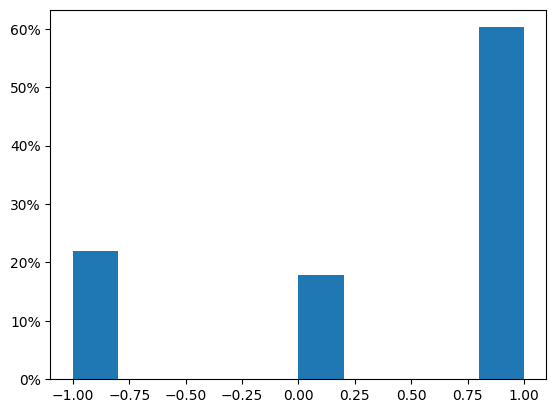

In [18]:
# target distribution

target_field = 'ret_120_h'

from matplotlib.ticker import PercentFormatter
plt.hist(df_merged[target_field], weights = np.ones(len(df_merged[target_field]))/len(df_merged[target_field]))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()



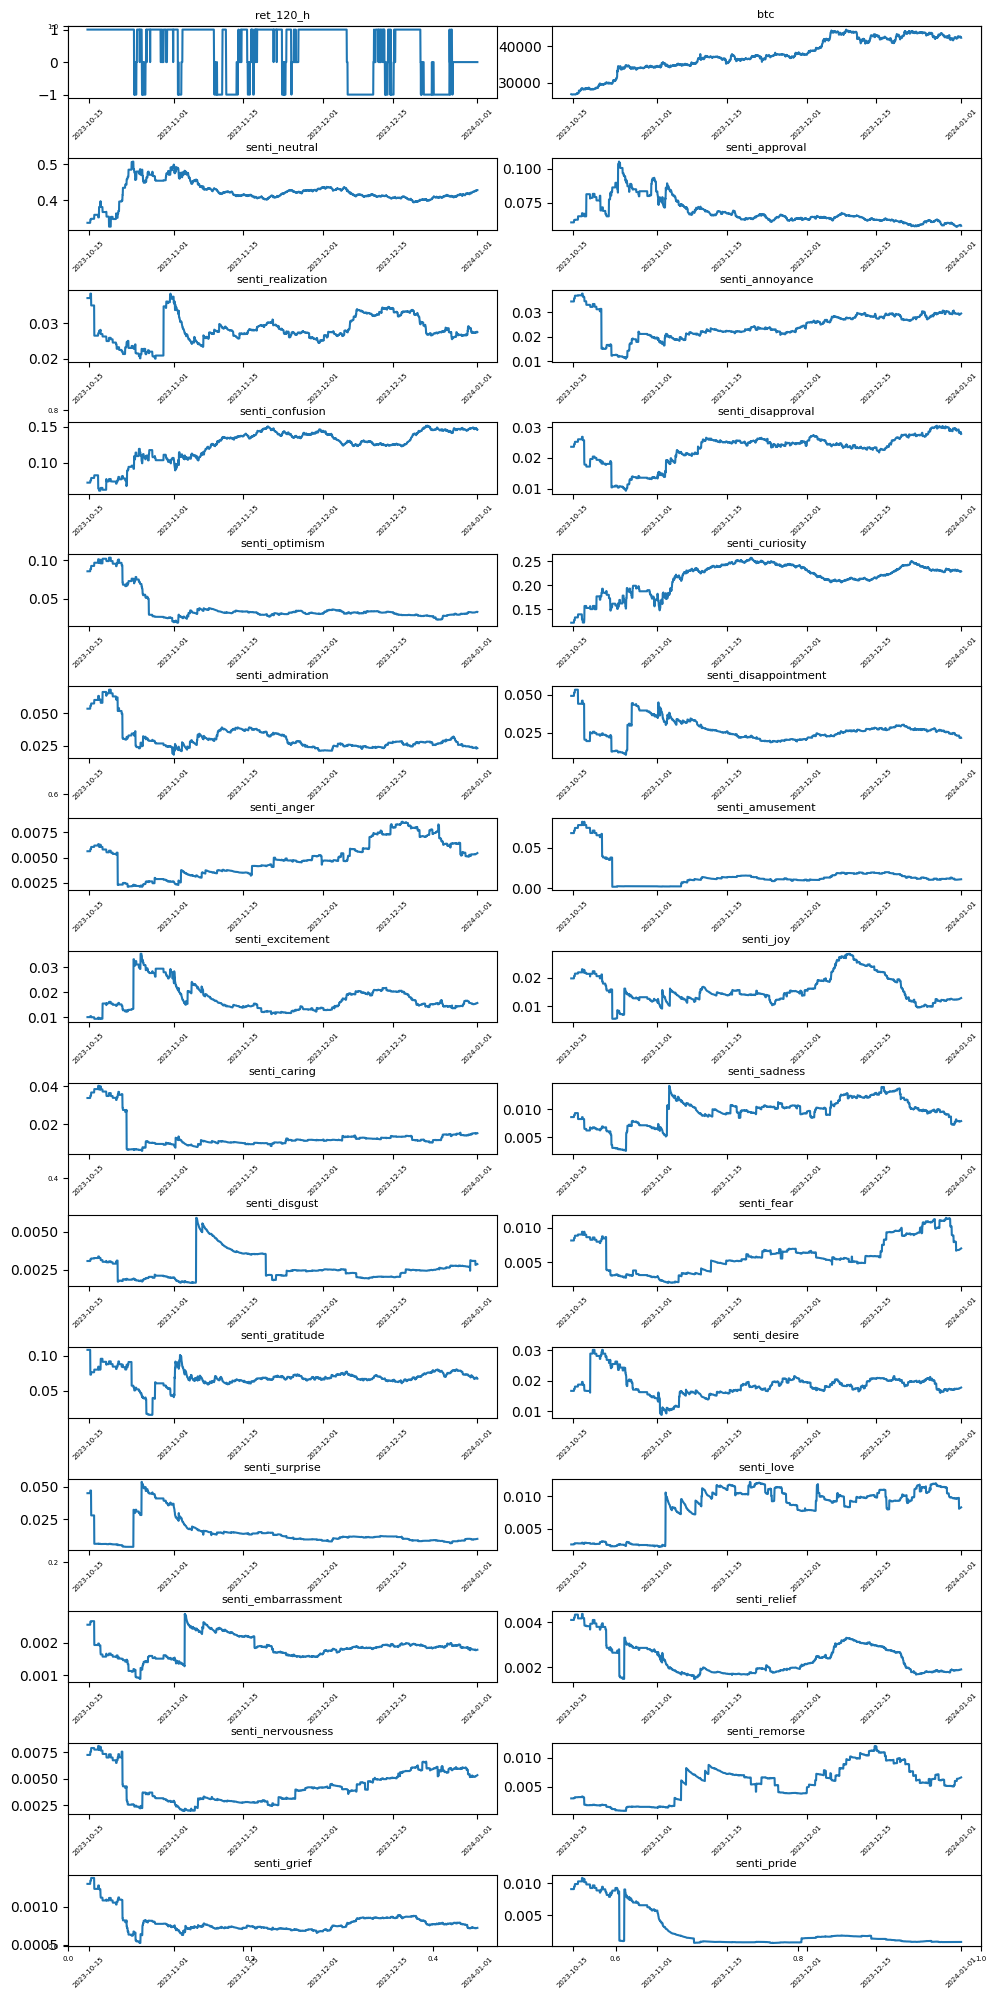

In [19]:
# plot timeseries of sentiment scores
# plot columns that contain 'sent_' in column name
# x-axis is 'timestamp'

df_plot_senti = df_merged.copy()
# senti, only
df_plot_senti = df_plot_senti[[col for col in df_plot_senti if 'senti_' in col]].copy()
# add time stamp colum
df_plot_senti.insert(0, 'timestamp', df_merged['timestamp'])
# add btc price
df_plot_senti.insert(1, 'btc', df_merged['close_price'])
# add return
df_plot_senti.insert(1, 'ret_120_h', df_merged['ret_120_h'])
# reset column indices
df_plot_senti.reset_index(drop=True, inplace=True)

# plot subplots , two per row
# plot settings
plt.figure(figsize=(10, 20))
plt.tick_params(axis='both', which='major', labelsize=5) # make axis ticker labels smaller

# plot subplots , two per row
num_plots = len(df_plot_senti.columns) - 1
num_rows = (num_plots + 1) // 2
num_cols = 2

title_size = 8
tick_label_size = 5
subplot_spacing = 0.1

for i in range(1, num_plots + 1):
    plt.subplot(num_rows, num_cols, i)
    plt.plot(df_plot_senti['timestamp'], df_plot_senti.iloc[:, i])
    plt.title(df_plot_senti.columns[i], fontsize=title_size)  # Set the size of the title
    plt.xticks(rotation=45, fontsize=tick_label_size)  # Set the size of the subplot tick labels
    plt.tight_layout(pad=subplot_spacing)  # Set the spacing between subplots

plt.show()




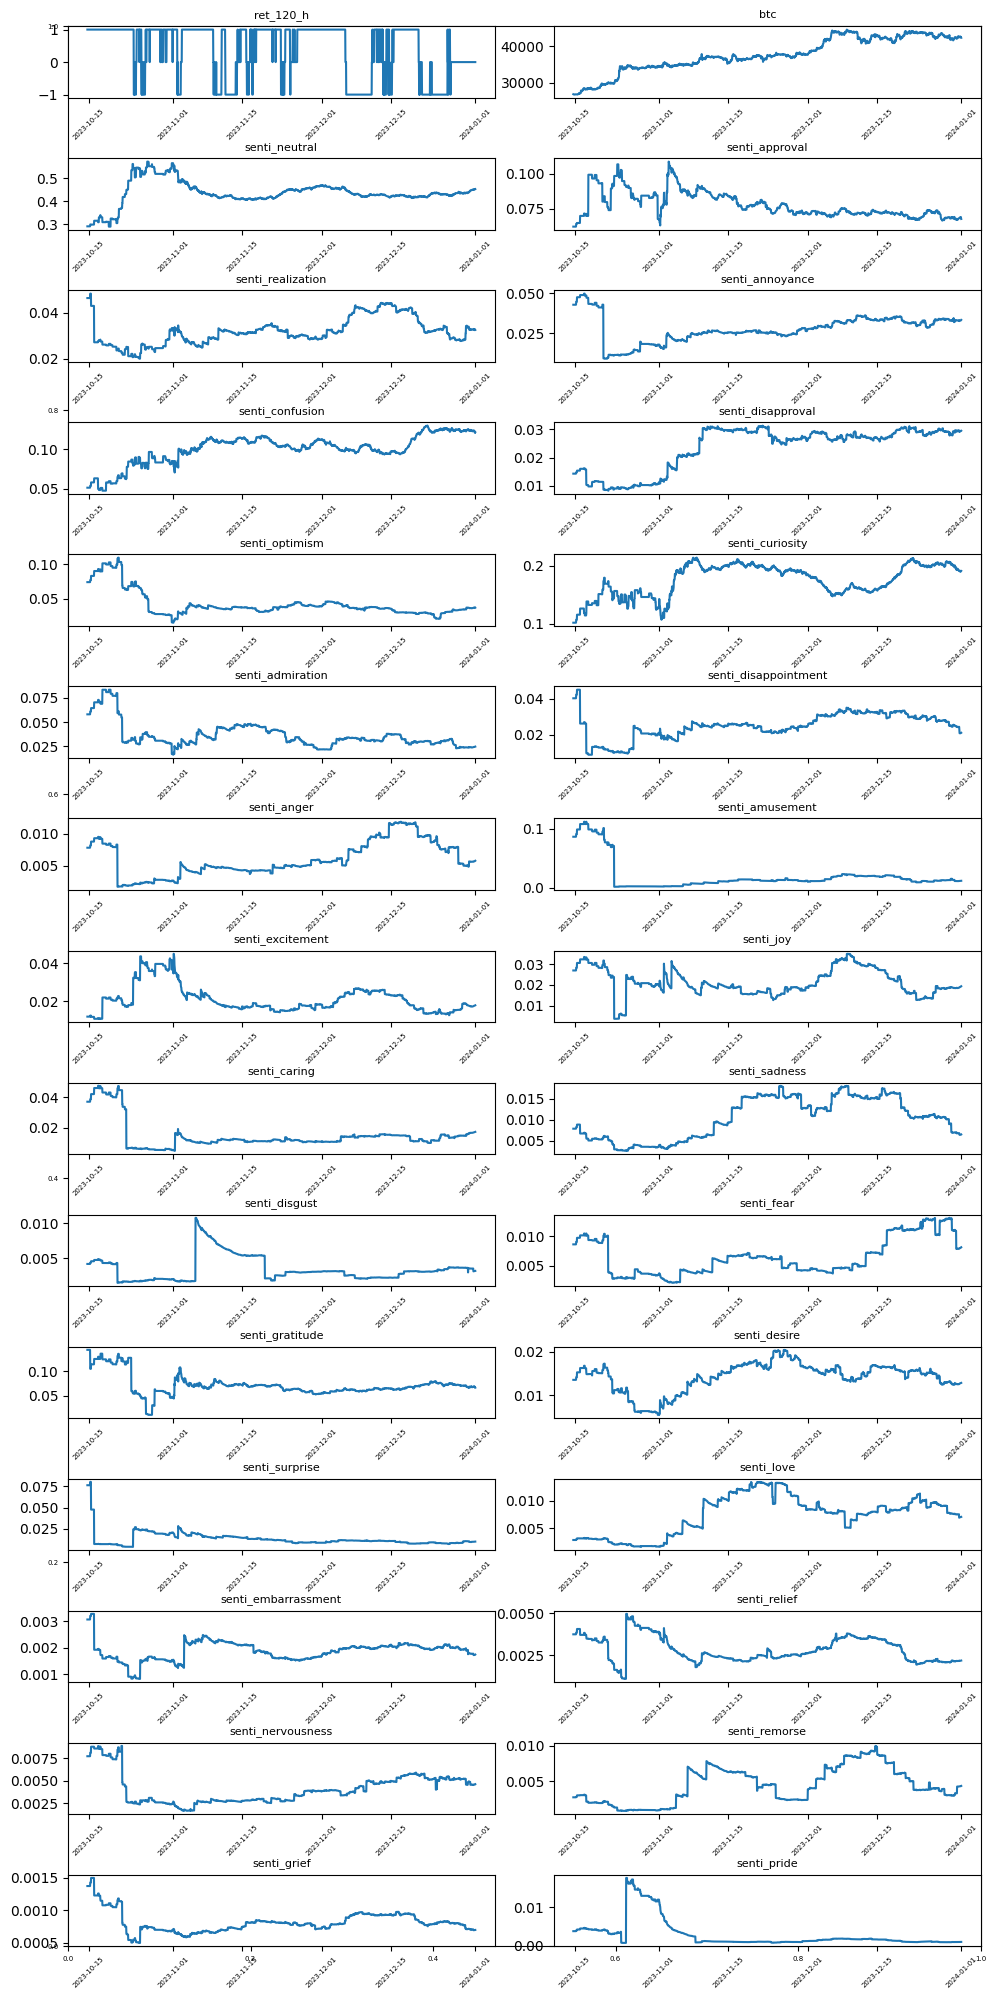

In [20]:
# plot timeseries of sentiment scores
# plot columns that contain 'sent_' in column name
# x-axis is 'timestamp'

df_plot_senti = df_merged_wgt.copy()
# senti, only
df_plot_senti = df_plot_senti[[col for col in df_plot_senti if 'senti_' in col]].copy()
# add time stamp colum
df_plot_senti.insert(0, 'timestamp', df_merged['timestamp'])
# add btc price
df_plot_senti.insert(1, 'btc', df_merged['close_price'])
# add return
df_plot_senti.insert(1, 'ret_120_h', df_merged['ret_120_h'])
# reset column indices
df_plot_senti.reset_index(drop=True, inplace=True)

# plot subplots , two per row
# plot settings
plt.figure(figsize=(10, 20))
plt.tick_params(axis='both', which='major', labelsize=5) # make axis ticker labels smaller

# plot subplots , two per row
num_plots = len(df_plot_senti.columns) - 1
num_rows = (num_plots + 1) // 2
num_cols = 2

title_size = 8
tick_label_size = 5
subplot_spacing = 0.1

for i in range(1, num_plots + 1):
    plt.subplot(num_rows, num_cols, i)
    plt.plot(df_plot_senti['timestamp'], df_plot_senti.iloc[:, i])
    plt.title(df_plot_senti.columns[i], fontsize=title_size)  # Set the size of the title
    plt.xticks(rotation=45, fontsize=tick_label_size)  # Set the size of the subplot tick labels
    plt.tight_layout(pad=subplot_spacing)  # Set the spacing between subplots

plt.show()




## Modeling

Rolling average

Weighted average

In [21]:
## packages
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# 
# #### Modeling Functions

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

### Time Series -- roling average, select X and y

In [30]:
## multinomial logistic regression
# target is a category: -1, 0, 1

# features: sentiment scores
######################### SELECT NON_WGT OR WGT ################################
# non weighted version
#X = df_merged[[col for col in df_merged.columns if 'senti_' in col]].copy()
#y = df_merged['ret_120_h'].copy()

# weighted version
X = df_merged_wgt[[col for col in df_merged_wgt.columns if 'senti_' in col]].copy()
y = df_merged_wgt['ret_1_h'].copy()

###################################################################################

# scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# fit multinomial logistic regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)

# initialize performance metrics
accuracy_scores = []
confusion_matrices = []

# perform time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # fit model
    model.fit(X_train, y_train)

    # predict
    y_prob = model.predict_proba(X_test)
    y_pred = model.predict(X_test)

    # accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

    # confusion matrix
    pd_conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted -1', 'Predicted 0', 'Predicted 1'], index=['Actual -1', 'Actual 0', 'Actual 1'])
    confusion_matrices.append(pd_conf_matrix)

# average accuracy
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)

# average confusion matrix
average_confusion_matrix = sum(confusion_matrices) / len(confusion_matrices)

print('Average Confusion Matrix:')
print(average_confusion_matrix)

print('Average Accuracy:', average_accuracy)


## other metrics
# what if model predicted highest probability every time?
#y_pred_constant = y.copy()
#y_pred_constant.iloc[:] = y.mean()
#y_pred_constant.iloc[:] = 1 # highest freq target
#regression_results(y, y_pred)
#print('')
#print('regression results if naive')
#regression_results(y, y_pred_constant)


Average Confusion Matrix:
           Predicted -1  Predicted 0  Predicted 1
Actual -1           0.0         20.0          3.8
Actual 0            0.0        209.0         53.6
Actual 1            0.0         21.6          5.0
Average Accuracy: 0.6837060702875399


### WRONG TRAIN SPLIT -- Rolling average (NOT weighted)

In [84]:
## multinomial logistic regression
# target is a category: -1, 0, 1

# features: sentiment scores
X = df_merged[[col for col in df_merged.columns if 'senti_' in col]].copy()
#print('x shape', X.shape)
# target: ret_120_h
y = df_merged['ret_120_h'].copy()
#y = df_merged['ret_96_h'].copy()

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# fit multinomial logistic regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)

# fit model
model.fit(X_train, y_train)

# predict
y_prob = model.predict_proba(X_test)
y_pred = model.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)

# confusion matrix
#confusion_matrix = confusion_matrix(y_test, y_pred)
# convert into dataframe
pd_conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted -1', 'Predicted 0', 'Predicted 1'], index=['Actual -1', 'Actual 0', 'Actual 1'])
# add sum row and column
pd_conf_matrix.loc['Total'] = pd_conf_matrix.sum()
pd_conf_matrix['Total'] = pd_conf_matrix.sum(axis=1)
print('Confusion Matrix:')
print(pd_conf_matrix)

print('Accuracy:', accuracy)


## other metrics
# what if model predicted highest probability every time?
y_pred_constant = y_test.copy()
#y_pred_constant.iloc[:] = y_test.mean()
y_pred_constant.iloc[:] = 1 # highest freq target
regression_results(y_test, y_pred)
print('')
print('regression results if naive')
regression_results(y_test, y_pred_constant)


Confusion Matrix:
           Predicted -1  Predicted 0  Predicted 1  Total
Actual -1            55            7           20     82
Actual 0              5           34           31     70
Actual 1              8           10          206    224
Total                68           51          257    376
Accuracy: 0.7845744680851063
explained_variance:  0.3695
r2:  0.3462
MAE:  0.2899
MSE:  0.4388
RMSE:  0.6624

regression results if naive
explained_variance:  0.0
r2:  -0.577
MAE:  0.6223
MSE:  1.0585
RMSE:  1.0288


### WRONG TRAIN SPLIT -- Weighted rolling average

In [86]:
## multinomial logistic regression
# target is a category: -1, 0, 1

# features: sentiment scores
X = df_merged_wgt[[col for col in df_merged_wgt.columns if 'senti_' in col]].copy()
#print('x shape', X.shape)
# target: ret_120_h
y = df_merged_wgt['ret_120_h'].copy()
#y = df_merged_wgt['ret_96_h'].copy()

# split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# fit multinomial logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# instantiate model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)

# fit model
model.fit(X_train, y_train)

# predict
y_prob = model.predict_proba(X_test)
y_pred = model.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)

# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
# convert into dataframe
pd_conf_matrix = pd.DataFrame(confusion_matrix, columns=['Predicted -1', 'Predicted 0', 'Predicted 1'], index=['Actual -1', 'Actual 0', 'Actual 1'])
# add sum row and column
pd_conf_matrix.loc['Total'] = pd_conf_matrix.sum()
pd_conf_matrix['Total'] = pd_conf_matrix.sum(axis=1)
print('Confusion Matrix:')
print(pd_conf_matrix)

print('Accuracy:', accuracy)

## other metrics
# what if model predicted highest probability every time?
y_pred_constant = y_test.copy()
#y_pred_constant.iloc[:] = y_test.mean()
y_pred_constant.iloc[:] = 1 # highest freq target
regression_results(y_test, y_pred)
print('')
print('regression results if naive')
regression_results(y_test, y_pred_constant)



Confusion Matrix:
           Predicted -1  Predicted 0  Predicted 1  Total
Actual -1            63            3           16     82
Actual 0              8           31           31     70
Actual 1             14            5          205    224
Total                85           39          252    376
Accuracy: 0.7952127659574468
explained_variance:  0.3449
r2:  0.3383
MAE:  0.2846
MSE:  0.4441
RMSE:  0.6664

regression results if naive
explained_variance:  0.0
r2:  -0.577
MAE:  0.6223
MSE:  1.0585
RMSE:  1.0288


In [87]:
# create dataframe of y_pred and actual y
df_compare = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}).reset_index(drop=True)
df_compare.describe()

# create dataframe out of y_prob
# recall, y_prob is nested and has 3 elements per row
df_prob = pd.DataFrame(y_prob, columns=['prob_down', 'prob_flat', 'prob_up'])
df_prob.describe()

# plot 
#df_compare.y_test.hist()


,prob_down,prob_flat,prob_up
count,3.760000e+02,3.760000e+02,376.000000
mean,2.229266e-01,1.863976e-01,0.590676
std,2.532477e-01,2.348679e-01,0.320453
min,1.440282e-11,1.433381e-12,0.000770
25%,1.555130e-02,3.318163e-02,0.324445
50%,1.142196e-01,1.086842e-01,0.644998
75%,3.925429e-01,2.484541e-01,0.890572
max,9.987355e-01,9.770737e-01,0.999999


## EDA - Rolling Senti, WEIGHTED -- grouped by target

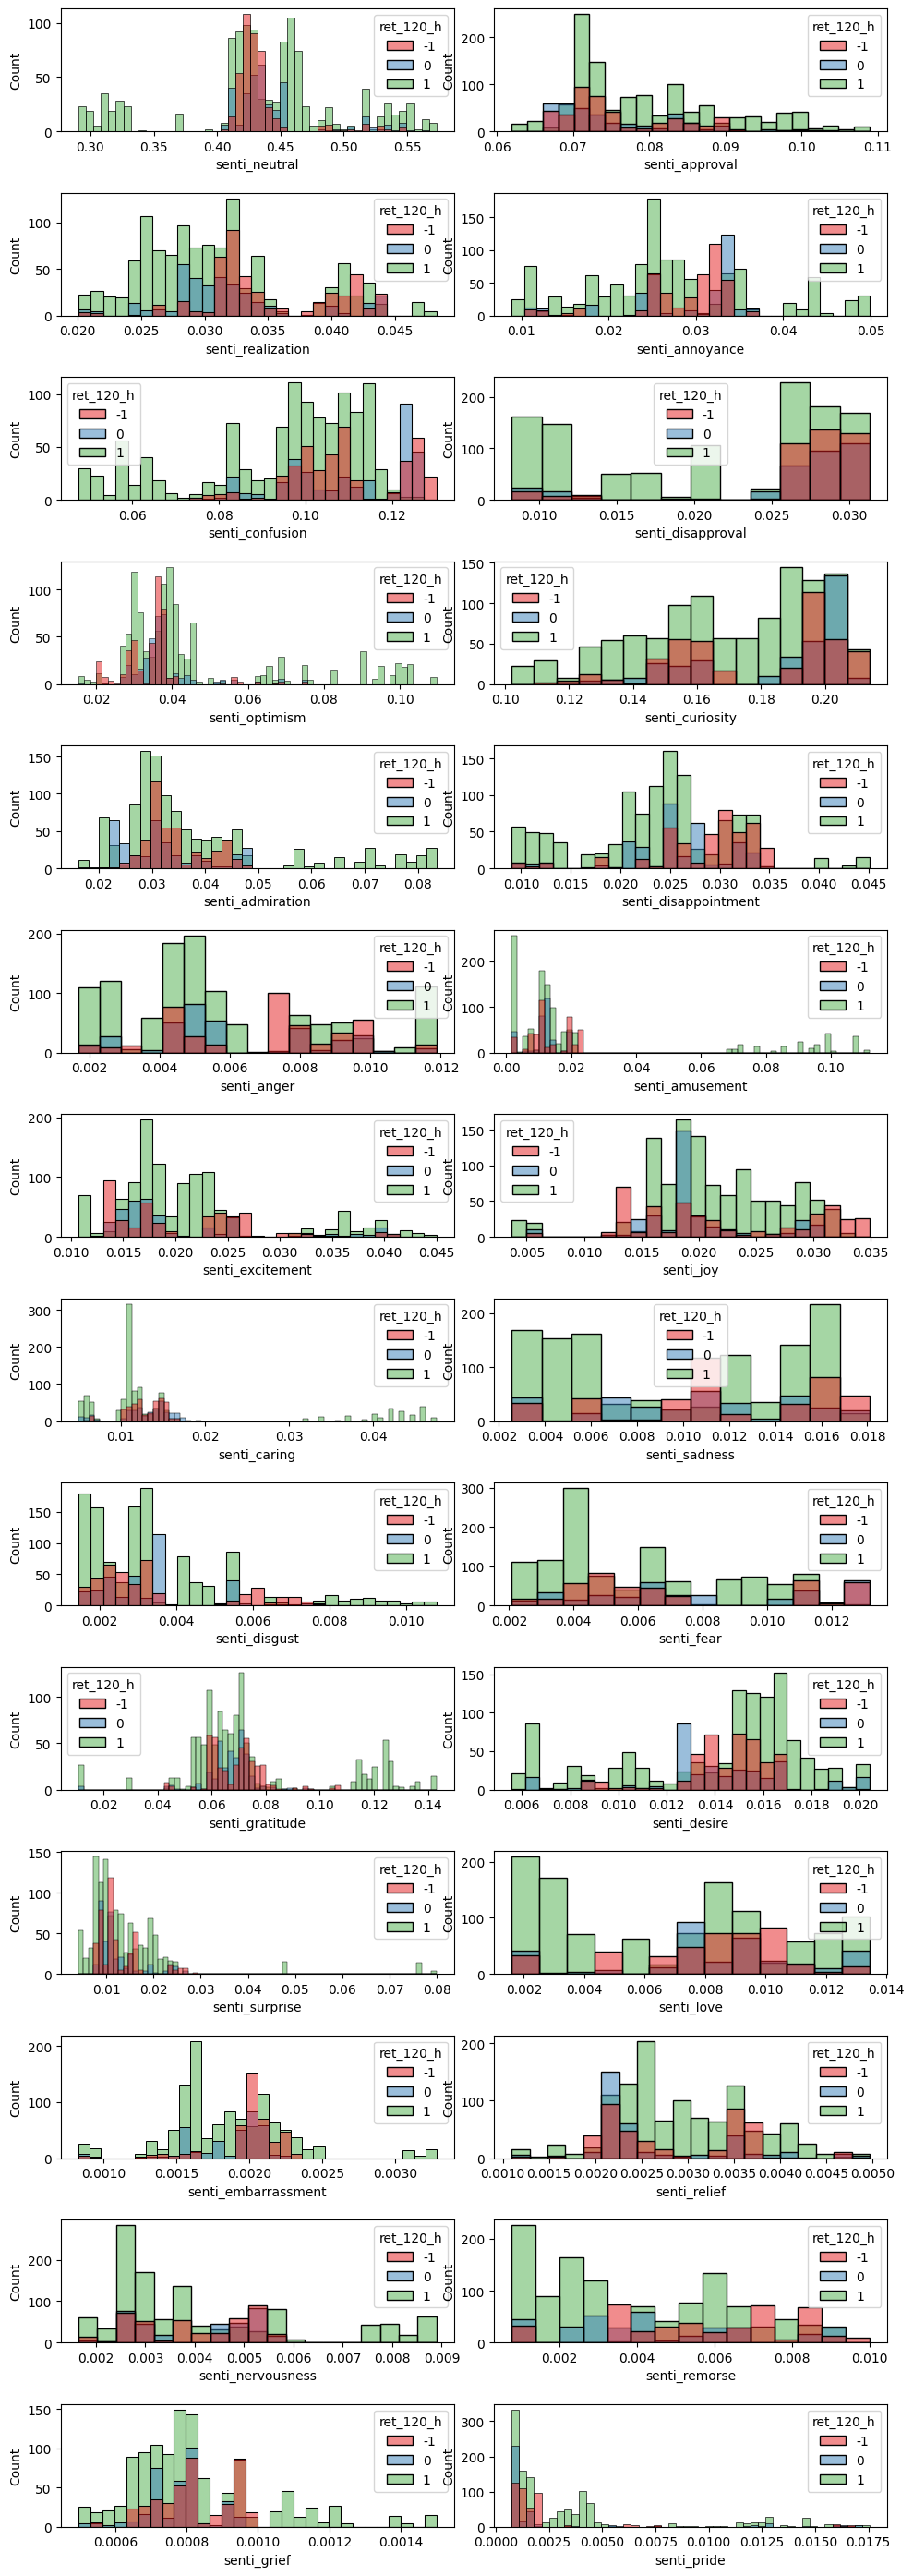

In [69]:
# subset 
df_merged_trimmed = df_merged_wgt.loc[:, df_merged_wgt.columns.str.startswith('senti_') | df_merged_wgt.columns.str.startswith('ret_')].copy()
df_merged_trimmed = df_merged_trimmed.dropna()

# Get the list of column names in df_merged_trimmed
columns = df_merged_trimmed.columns
# columns contain 'senti_'
columns_senti = [col for col in columns if 'senti_' in col]

# Calculate the number of rows and columns for the subplots
num_rows = len(columns_senti) // 2 + len(columns_senti) % 2
num_cols = 2

# Create a multi-grid plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 1*len(columns_senti)))

# select field to group by
field_group_by = 'ret_120_h'
# Iterate over each column and plot the histogram
for i, column in enumerate(columns_senti):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(data=df_merged_trimmed, x=column, hue=field_group_by, ax=axes[row, col], palette = 'Set1')

# Adjust the layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.1)

# Show the plot
plt.show()




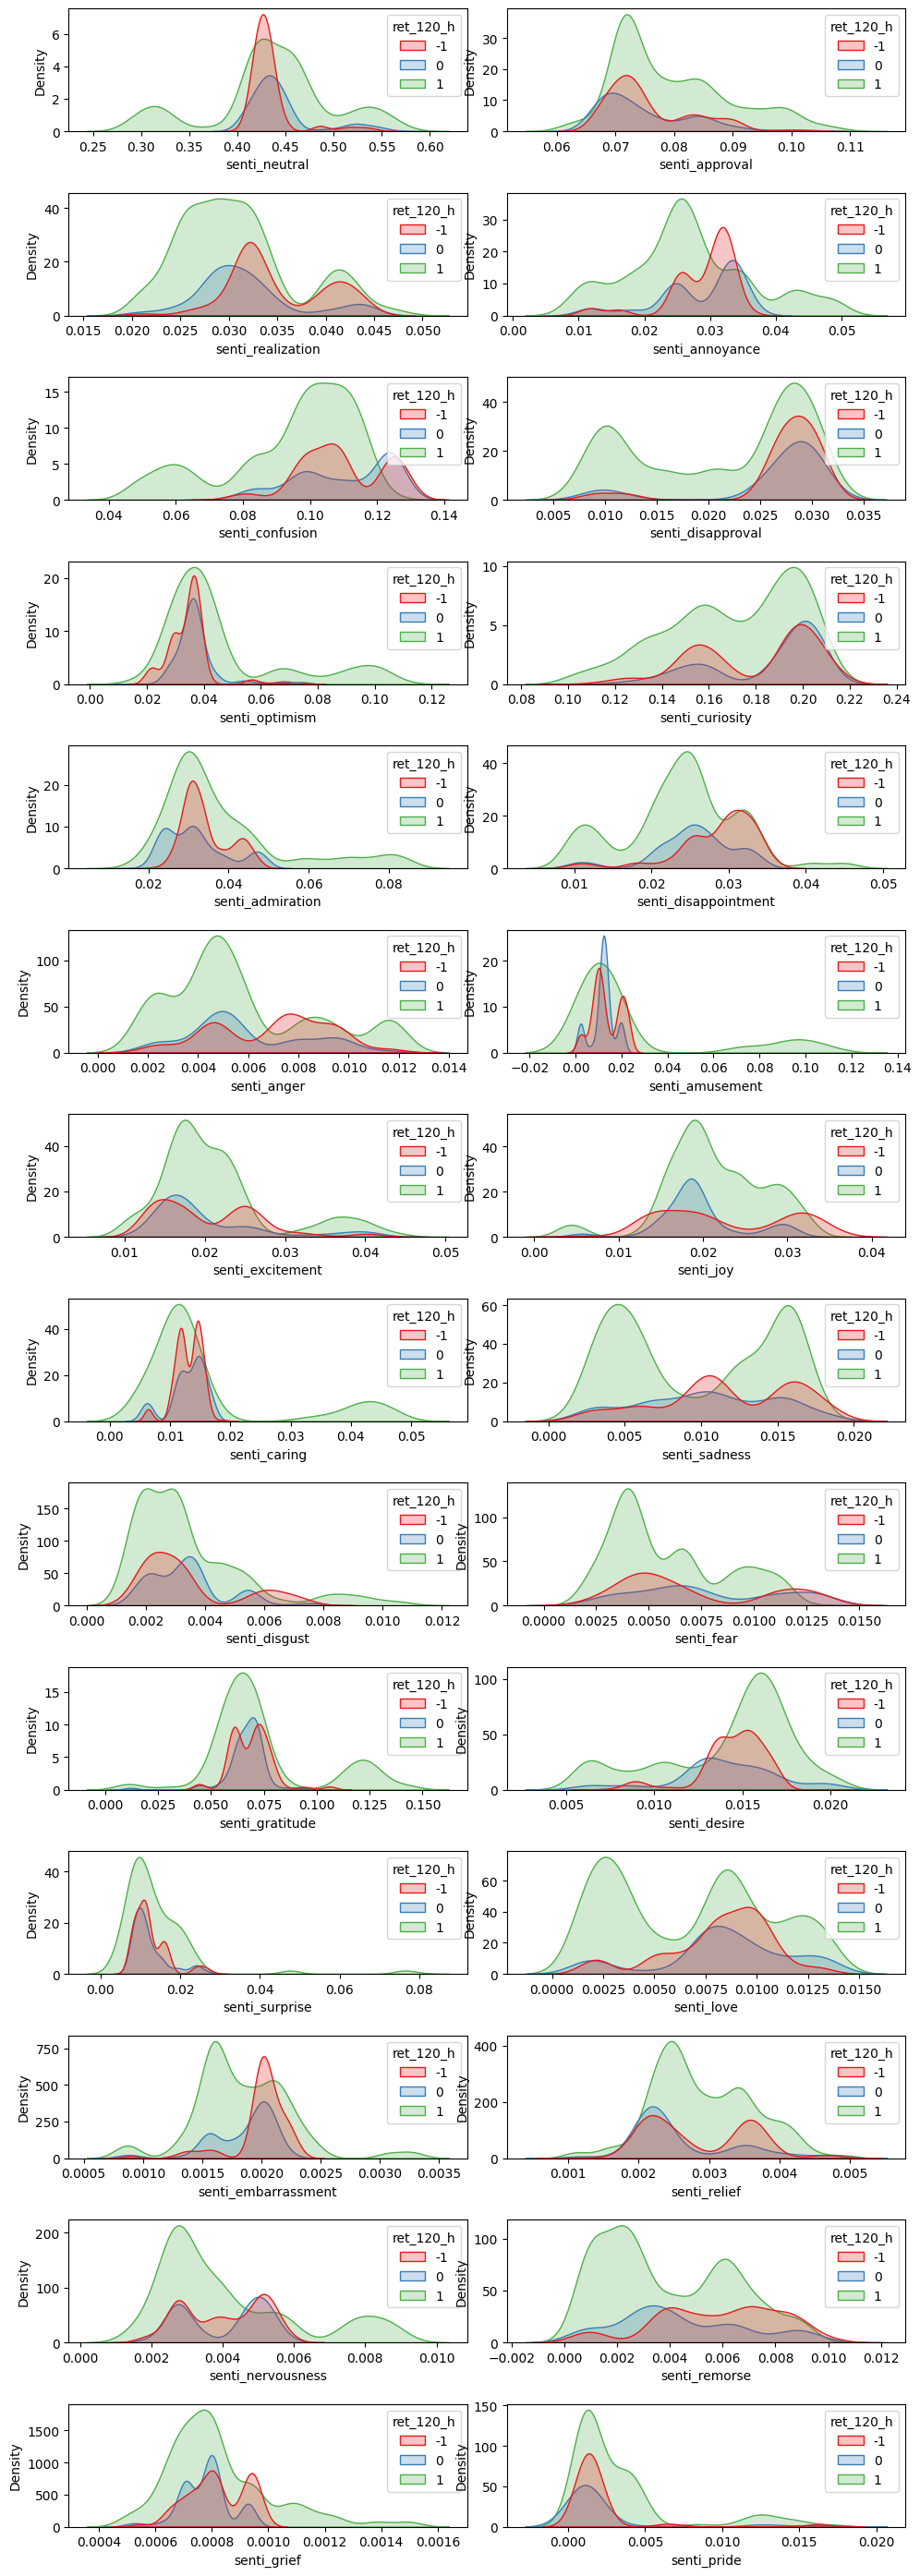

In [70]:
# df_merged_trimmed is a subset of df_merged, containing columns that start with 'senti_' and 'ret_'
df_merged_trimmed = df_merged_wgt.loc[:, df_merged_wgt.columns.str.startswith('senti_') | df_merged_wgt.columns.str.startswith('ret_')].copy()
df_merged_trimmed = df_merged_trimmed.dropna()


#sns.displot(df_merged_trimmed, x = 'senti_curiosity', hue = 'ret_120_h', kind = 'kde')
#sns.displot(df_merged_trimmed, x = df_merged_trimmed.senti_curiosity.values, 
#hue = df_merged_trimmed.ret_120_h.values, kind = 'kde')


# use matplot plt to subplot a histogram of each column, with color representing the target variable
# target = 'ret_120_h'
# have each subplot on a grid joined together

# Get the list of column names in df_merged_trimmed
columns = df_merged_trimmed.columns
# columns contain 'senti_'
columns_senti = [col for col in columns if 'senti_' in col]

# Calculate the number of rows and columns for the subplots
num_rows = len(columns_senti) // 2 + len(columns_senti) % 2
num_cols = 2

# Create a multi-grid plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 1*len(columns_senti)))

# Define the color palette
#color_palette = ['red', 'blue', 'green', 'orange', 'purple']

# select field to group by
field_group_by = 'ret_120_h'
# Iterate over each column and plot the distribution
for i, column in enumerate(columns_senti):
    row = i // num_cols
    col = i % num_cols
    #sns.kdeplot(data=df_merged_trimmed, x=column, fill=True, ax=axes[row, col])
    sns.kdeplot(data=df_merged_trimmed, x=column, hue=field_group_by, 
                fill=True, ax=axes[row, col], palette = 'Set1')

# Adjust the layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.1)

# Show the plot
plt.show()





## EDA - Rolling Senti, NOT weighed -- grouped by target

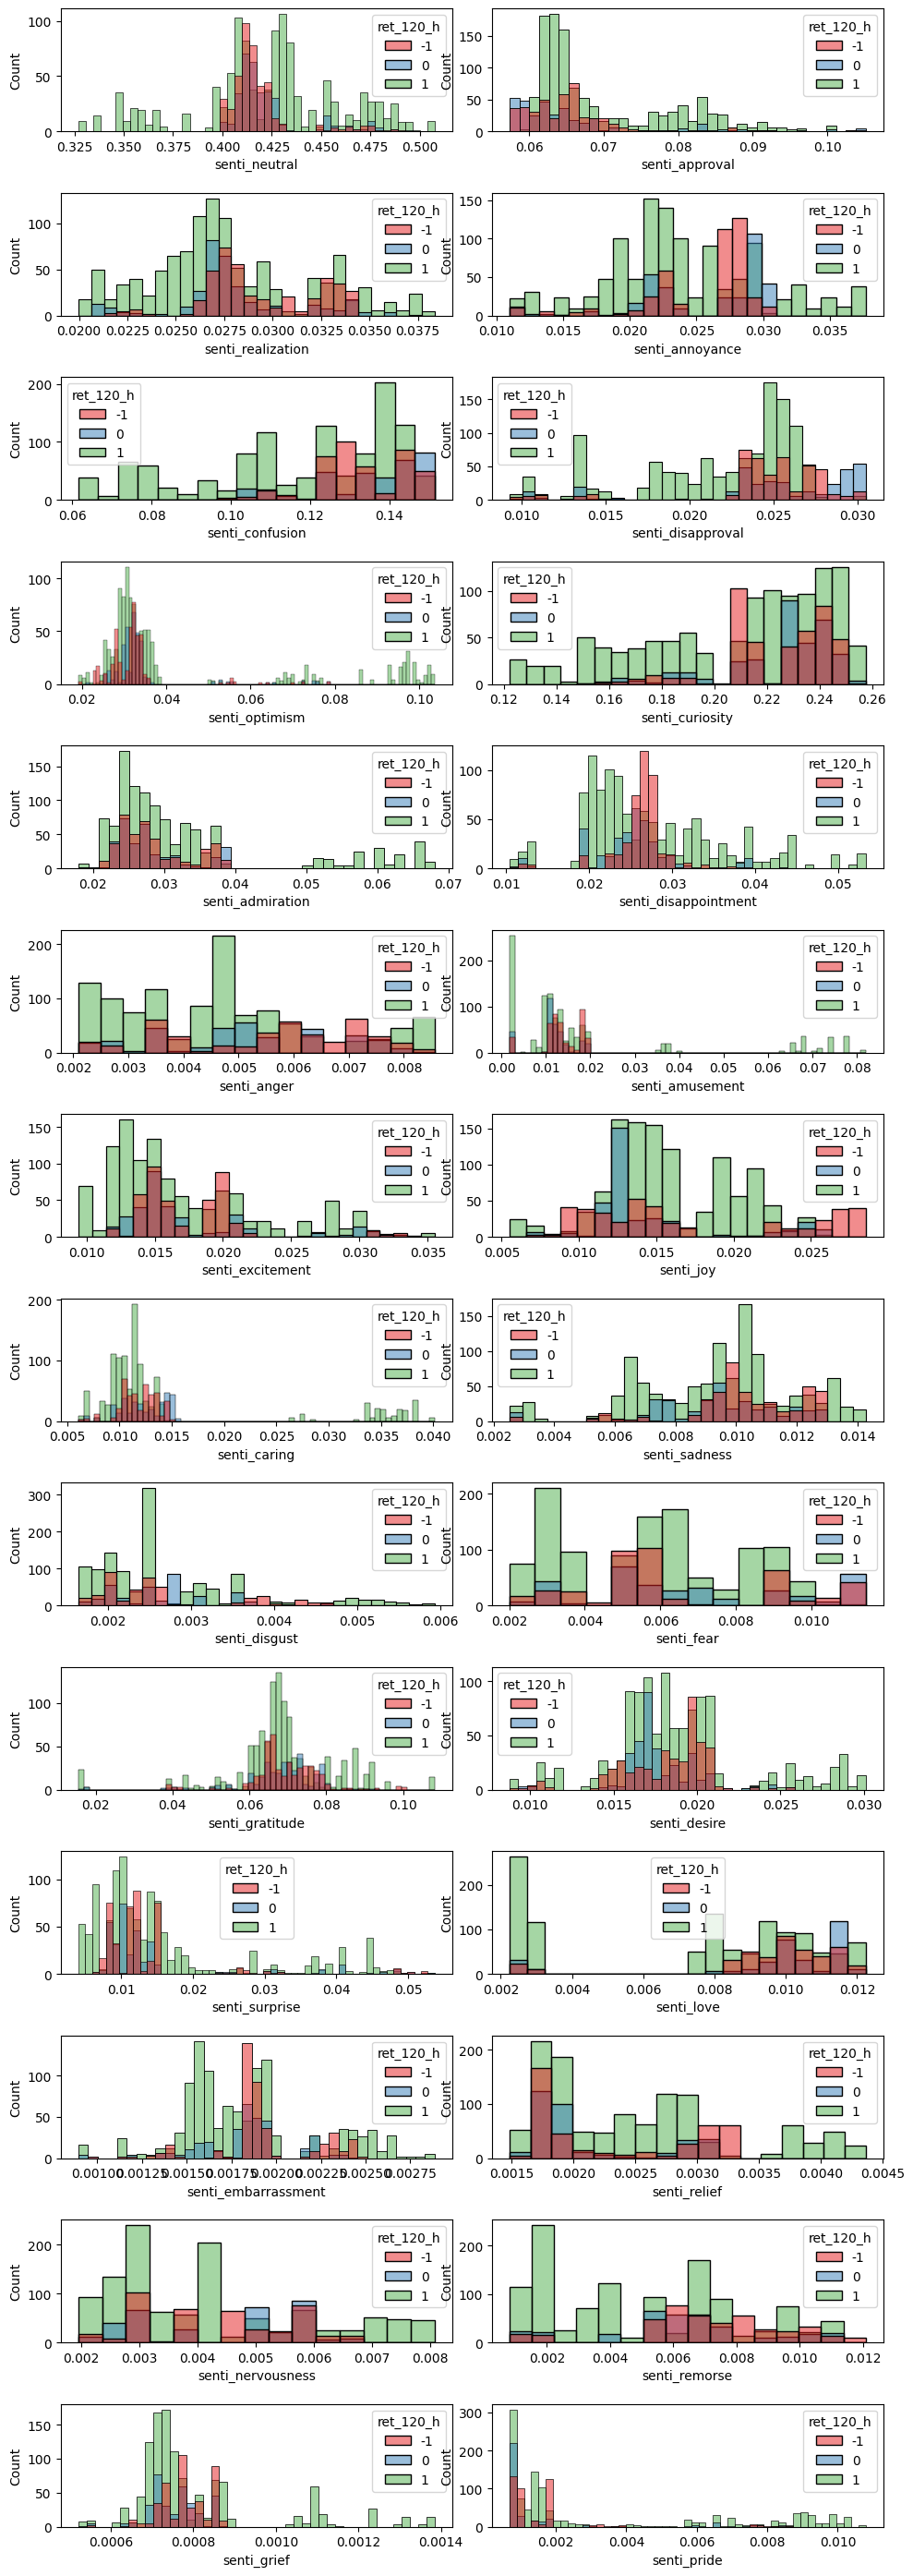

In [72]:
# subset 
df_merged_trimmed = df_merged.loc[:, df_merged.columns.str.startswith('senti_') | df_merged.columns.str.startswith('ret_')].copy()
df_merged_trimmed = df_merged_trimmed.dropna()

# Get the list of column names in df_merged_trimmed
columns = df_merged_trimmed.columns
# columns contain 'senti_'
columns_senti = [col for col in columns if 'senti_' in col]

# Calculate the number of rows and columns for the subplots
num_rows = len(columns_senti) // 2 + len(columns_senti) % 2
num_cols = 2

# Create a multi-grid plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 1*len(columns_senti)))

# select field to group by
field_group_by = 'ret_120_h'
# Iterate over each column and plot the histogram
for i, column in enumerate(columns_senti):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(data=df_merged_trimmed, x=column, hue=field_group_by, ax=axes[row, col], palette = 'Set1')

# Adjust the layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.1)

# Show the plot
plt.show()




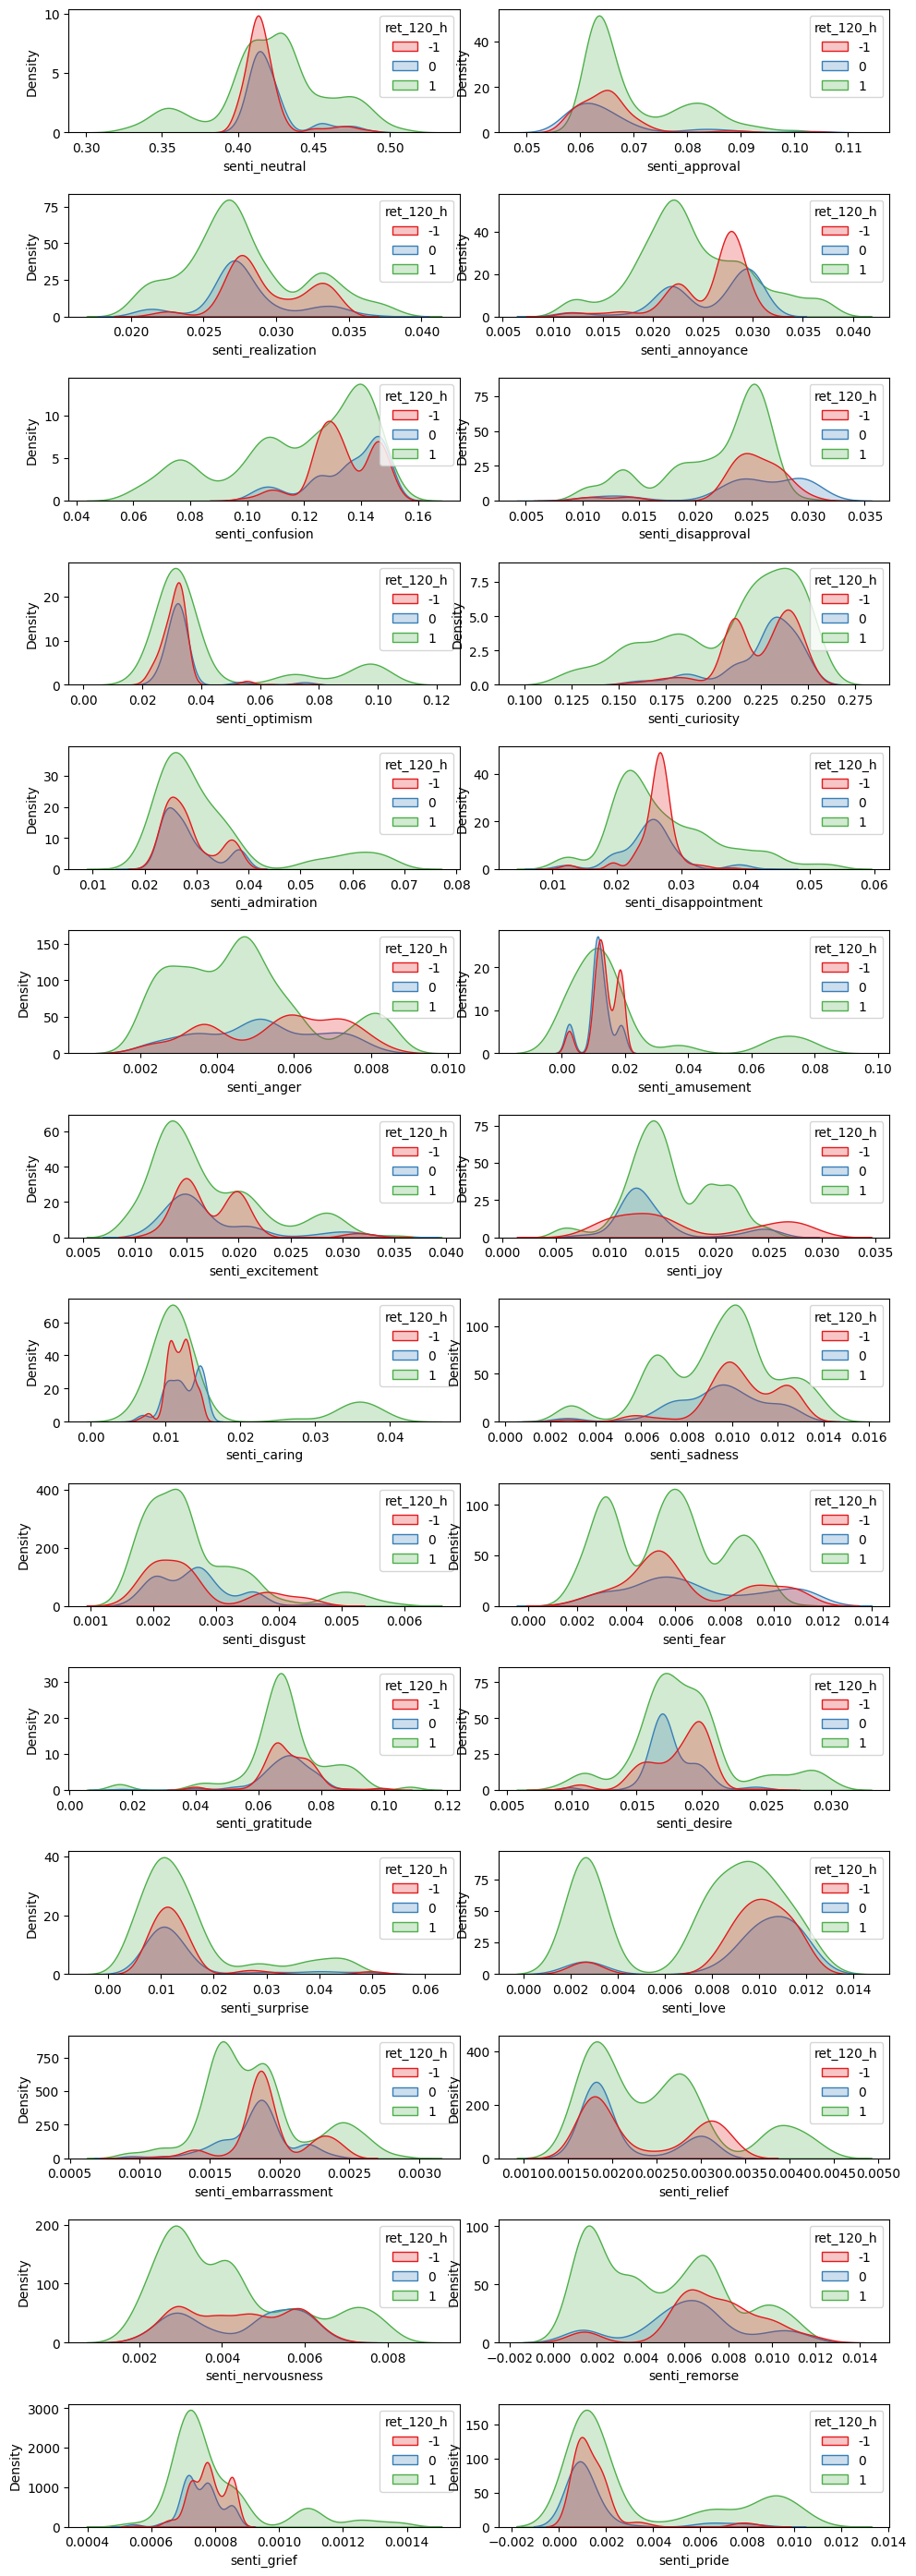

In [75]:
# df_merged_trimmed is a subset of df_merged, containing columns that start with 'senti_' and 'ret_'
df_merged_trimmed = df_merged.loc[:, df_merged.columns.str.startswith('senti_') | df_merged.columns.str.startswith('ret_')].copy()
df_merged_trimmed = df_merged_trimmed.dropna()


#sns.displot(df_merged_trimmed, x = 'senti_curiosity', hue = 'ret_120_h', kind = 'kde')
#sns.displot(df_merged_trimmed, x = df_merged_trimmed.senti_curiosity.values, 
#hue = df_merged_trimmed.ret_120_h.values, kind = 'kde')


# use matplot plt to subplot a histogram of each column, with color representing the target variable
# target = 'ret_120_h'
# have each subplot on a grid joined together

# Get the list of column names in df_merged_trimmed
columns = df_merged_trimmed.columns
# columns contain 'senti_'
columns_senti = [col for col in columns if 'senti_' in col]

# Calculate the number of rows and columns for the subplots
num_rows = len(columns_senti) // 2 + len(columns_senti) % 2
num_cols = 2

# Create a multi-grid plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 1*len(columns_senti)))

# Define the color palette
#color_palette = ['red', 'blue', 'green', 'orange', 'purple']

# select field to group by
field_group_by = 'ret_120_h'
# Iterate over each column and plot the distribution
for i, column in enumerate(columns_senti):
    row = i // num_cols
    col = i % num_cols
    #sns.kdeplot(data=df_merged_trimmed, x=column, fill=True, ax=axes[row, col])
    sns.kdeplot(data=df_merged_trimmed, x=column, hue=field_group_by, 
                fill=True, ax=axes[row, col], palette = 'Set1')

# Adjust the layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.1)

# Show the plot
plt.show()





# MISC

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
# Preprocess text (username and link placeholders)
#def preprocess(text):
#    new_text = []
#    for t in text.split(" "):
#        t = '@user' if t.startswith('@') and len(t) > 1 else t
#        t = 'http' if t.startswith('http') else t
#        new_text.append(t)
#    return " ".join(new_text)



MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

# PT
#model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)
#text = "Covid cases are increasing fast!"
#text = preprocess(text)
#encoded_input = tokenizer(text, return_tensors='pt')
#output = model(**encoded_input)
#scores = output[0][0].detach().numpy()
#scores = softmax(scores)

# # TF
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)
#text = "Covid cases are increasing fast!"
#encoded_input = tokenizer(text, return_tensors='tf')

encoded_input = tokenizer(df_sub.selftext.astype("string").to_list(), 
                          return_tensors='tf')

output = model(encoded_input)
scores = output[0][0].numpy()
scores = softmax(scores)


# Print labels and scores
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")
    


In [ ]:
df_sent